In [1]:
import os 
os.chdir("../..")
import random
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from scripts.python.PdfParse import *
from scripts.python.utils import *
from scripts.python.ts_utils import *

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [2]:
fiji_folder = os.getcwd() + "/data/tourism/fiji/intermediate/"
fiji_files = os.listdir(fiji_folder)
filepaths = [fiji_folder + file for file in fiji_files]

## Fiji Census

In [4]:
for file in filepaths:
    if "by_month" in file:
        break

df = pd.read_csv(file).drop("Unnamed: 0", axis=1)
df.head(5)

,year,dates,australia,newzealand,usa,canada,unitedkingdom,continentaleurope,japan,southkorea,china,india,hongkong,rest ofasia,pacificislands,others,total
0,2020,2020-01-01,29886,11316,6209,1075,1423,2802,726,316,4469,367,65,1238,5022,472,65386
1,2020,2020-02-01,16690,8242,7020,1167,1286,2524,1042,161,1661,469,35,1014,4685,347,46343
2,2020,2020-03-01,11260,5520,3835,623,723,1361,460,28,835,276,55,896,1923,177,27972
3,2020,2020-04-01,0,5,2,0,0,0,0,6,277,2,0,386,0,0,678
4,2020,2020-05-01,2,2,0,0,0,2,0,6,276,0,0,412,9,0,709


## Aviation Data

In [5]:
aviation_path = os.getcwd() + "/data/tourism/aviation_seats_flights_pic.xlsx"
aviation = pd.read_excel(aviation_path)
aviation.head(5)

,Country,ISO,Region,Date,Aircraft_type,Seats_arrivals_domestic,Seats_arrivals_interregional,Seats_arrivals_intraregional,Seats_arrivals_intl,Seats_arrivals_total,Available_seat_kilometers,Number_of_flights_domestic,Number_of_flights_interregional,Number_of_flights_intraregional,Number_of_flights_intl,Number_of_flights_total
0,Fiji,FJ,East Asia & Pacific,2019-01-01,passenger,839,273,3480,3753,4592,1.430416e+07,8,1,10,11,19
1,Fiji,FJ,East Asia & Pacific,2019-01-02,passenger,974,313,3471,3784,4758,1.495610e+07,8,1,10,11,19
2,Fiji,FJ,East Asia & Pacific,2019-01-03,passenger,1190,443,3675,4118,5308,1.592143e+07,10,2,12,14,24
3,Fiji,FJ,East Asia & Pacific,2019-01-04,passenger,831,586,3159,3745,4576,1.457334e+07,7,2,12,14,21
4,Fiji,FJ,East Asia & Pacific,2019-01-05,passenger,744,273,4752,5025,5769,1.773449e+07,7,1,12,13,20


In [6]:
fj_avi = (aviation[(aviation.ISO == "FJ") & (aviation.Aircraft_type == "passenger")]
          .reset_index()
          .drop("index", axis=1)
          [["Date", "Number_of_flights_intl", "Number_of_flights_total",
            "Seats_arrivals_intl", "Seats_arrivals_total"]])

dates = pd.DataFrame(pd.date_range(start="2020-01-01",
                                   end="2022-08-01"), columns=["Date"])

fj_avi = dates.merge(fj_avi, how="left", on="Date")
fj_avi["Date"] = pd.to_datetime(fj_avi["Date"])
fj_avi["Month"], fj_avi["Year"] = fj_avi["Date"].dt.month, fj_avi["Date"].dt.year

fj_avi_19_22 = fj_avi.groupby(by=["Year", "Month"]).sum().reset_index()
fj_merged = pd.concat([fj_avi_19_22, df], axis=1)



fj_merged = fj_merged.drop("year", axis=1)
fj_merged.columns = fj_merged.columns.str.lower()
fj_merged.to_csv(fiji_folder + "fj_merged.csv", encoding="utf-8")
fj_merged.head(5)

,year,month,number_of_flights_intl,number_of_flights_total,seats_arrivals_intl,seats_arrivals_total,dates,australia,newzealand,usa,...,continentaleurope,japan,southkorea,china,india,hongkong,rest ofasia,pacificislands,others,total
0,2020,1,342.0,732.0,107570.0,142531.0,2020-01-01,29886,11316,6209,...,2802,726,316,4469,367,65,1238,5022,472,65386
1,2020,2,248.0,522.0,65187.0,90950.0,2020-02-01,16690,8242,7020,...,2524,1042,161,1661,469,35,1014,4685,347,46343
2,2020,3,173.0,405.0,45688.0,65205.0,2020-03-01,11260,5520,3835,...,1361,460,28,835,276,55,896,1923,177,27972
3,2020,4,9.0,58.0,1922.0,3869.0,2020-04-01,0,5,2,...,0,0,6,277,2,0,386,0,0,678
4,2020,5,5.0,153.0,925.0,10087.0,2020-05-01,2,2,0,...,2,0,6,276,0,0,412,9,0,709


## EDA
### Visualization

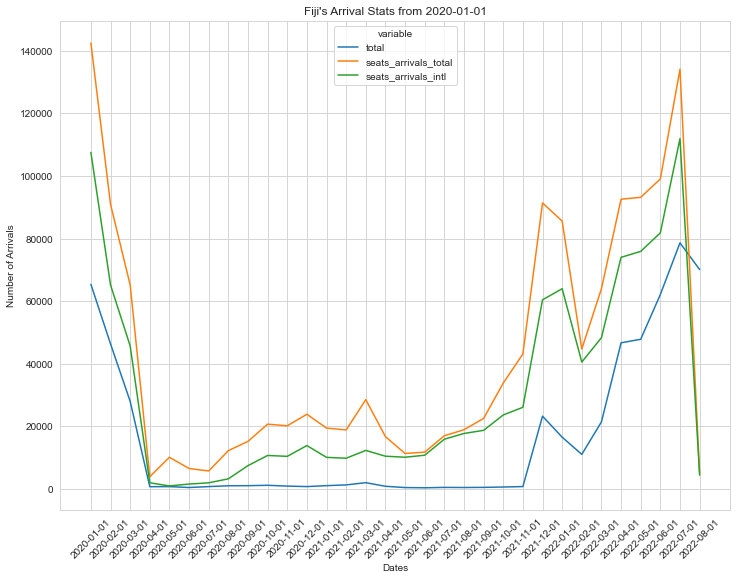

In [7]:
viz_df = fj_merged[["dates", "total", "seats_arrivals_total", "seats_arrivals_intl"]]
viz_df = pd.melt(viz_df, "dates")

plt.figure(figsize=(12,9)) 
sns.set_style("whitegrid")
sns.lineplot(data=viz_df, x="dates", y="value", hue="variable")
plt.xlabel("Dates")
plt.ylabel("Number of Arrivals")
plt.title("Fiji's Arrival Stats from 2020-01-01")
plt.xticks(rotation=45)
plt.show()

### Correlation
#### Pearson Correlaton Coefficient

In [8]:
from scipy.stats import pearsonr


corr_seats_max, _ = pearsonr(fj_merged["seats_arrivals_total"], fj_merged["total"])
corr_seat_flight_max, _ = pearsonr(fj_merged["number_of_flights_total"], fj_merged["total"])
print(" Using the Maximum Values of the duplicated rows:  \n",
f"Pearson Correlation between FlightRadar's Seats Arrival and FJ's census data is{corr_seats_max: .4f}. \n",
f"Pearson Correlation between FlightRadar's # of Flights Arrival and FJ's census data is{corr_seat_flight_max: .4f}.")

# Correlation Matrix
cols = ["seats_arrivals_intl", "seats_arrivals_total",
        "number_of_flights_total", "number_of_flights_intl", "total"]
corr_matrix_max = fj_merged[cols].corr()
corr_matrix_max

 Using the Maximum Values of the duplicated rows:  
 Pearson Correlation between FlightRadar's Seats Arrival and FJ's census data is 0.7835. 
 Pearson Correlation between FlightRadar's # of Flights Arrival and FJ's census data is 0.7121.


,seats_arrivals_intl,seats_arrivals_total,number_of_flights_total,number_of_flights_intl,total
seats_arrivals_intl,1.000000,0.990794,0.936246,0.979157,0.807567
seats_arrivals_total,0.990794,1.000000,0.971783,0.980772,0.783485
number_of_flights_total,0.936246,0.971783,1.000000,0.958268,0.712115
number_of_flights_intl,0.979157,0.980772,0.958268,1.000000,0.786754
total,0.807567,0.783485,0.712115,0.786754,1.000000


#### Cross-Correlation

In [9]:
cc_df = cross_corr_df(fj_merged, "seats_arrivals_intl", "total")
cc_df.head(5)

,lag,cross_corr_coef
0,0,0.807567
1,1,0.502618
2,2,0.274523
3,3,0.115694
4,4,-0.000277


### Converting to Stationary

In [10]:
excl_cols = ["year", "month", "dates"]
incl_cols = fj_merged.columns[~fj_merged.columns.isin(excl_cols)]

# Create a df for log transformation
fj_log = pd.DataFrame()
fj_log[excl_cols] = fj_merged[excl_cols]
for col in incl_cols:
    fj_log[col+str("_log")] = np.log(fj_merged[col]+1)
    
log_cols = [colname for colname in fj_log.columns if "log" in colname]
fj_log.head(5)

,year,month,dates,number_of_flights_intl_log,number_of_flights_total_log,seats_arrivals_intl_log,seats_arrivals_total_log,australia_log,newzealand_log,usa_log,...,continentaleurope_log,japan_log,southkorea_log,china_log,india_log,hongkong_log,rest ofasia_log,pacificislands_log,others_log,total_log
0,2020,1,2020-01-01,5.837730,6.597146,11.585906,11.867322,10.305179,9.334061,8.733916,...,7.938446,6.588926,5.758902,8.405144,5.908083,4.189655,7.122060,8.521783,6.159095,11.088079
1,2020,2,2020-02-01,5.517453,6.259581,11.085031,11.418076,9.722625,9.017120,8.856661,...,7.833996,6.949856,5.087596,7.415777,6.152733,3.583519,6.922644,8.452335,5.852202,10.743847
2,2020,3,2020-03-01,5.159055,6.006353,10.729613,11.085307,9.329101,8.616314,8.252185,...,7.216709,6.133398,3.367296,6.728629,5.624018,4.025352,6.799056,7.562162,5.181784,10.238995
3,2020,4,2020-04-01,2.302585,4.077537,7.561642,8.261010,0.000000,1.791759,1.098612,...,0.000000,0.000000,1.945910,5.627621,1.098612,0.000000,5.958425,0.000000,0.000000,6.520621
4,2020,5,2020-05-01,1.791759,5.036953,6.830874,9.219102,1.098612,1.098612,0.000000,...,1.098612,0.000000,1.945910,5.624018,0.000000,0.000000,6.023448,2.302585,0.000000,6.565265


#### Stationarity

In [13]:
diff_cols = ["total", "seats_arrivals_intl"]
fj_diff = fj_merged[diff_cols].diff().dropna()
fj_diff2 = fj_diff.diff().dropna()
get_adf_df(fj_diff2, diff_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-2.495311,0.116619,6.0,23.0,-3.752928,-2.998500,-2.638967
seats_arrivals_intl,-2.890819,0.046426,7.0,22.0,-3.769733,-3.005426,-2.642501


In [27]:
# Check stationarity after log transformation
get_adf_df(fj_log, log_cols)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
number_of_flights_intl_log,-2.319541,0.165743,0.0,31.0,-3.661429,-2.960525,-2.619319
number_of_flights_total_log,-2.719118,0.070788,0.0,31.0,-3.661429,-2.960525,-2.619319
seats_arrivals_intl_log,-2.154920,0.223011,0.0,31.0,-3.661429,-2.960525,-2.619319
seats_arrivals_total_log,-2.669738,0.079423,0.0,31.0,-3.661429,-2.960525,-2.619319
australia_log,-1.771089,0.394907,0.0,31.0,-3.661429,-2.960525,-2.619319
newzealand_log,-1.360059,0.601268,0.0,31.0,-3.661429,-2.960525,-2.619319
usa_log,-1.693016,0.434714,0.0,31.0,-3.661429,-2.960525,-2.619319
canada_log,-1.702851,0.429644,0.0,31.0,-3.661429,-2.960525,-2.619319
unitedkingdom_log,-2.168854,0.217743,0.0,31.0,-3.661429,-2.960525,-2.619319
continentaleurope_log,-2.303857,0.170727,0.0,31.0,-3.661429,-2.960525,-2.619319


In [10]:
# Check stationarity after log-diff transformation
fj_log_diff = fj_log[log_cols].diff()
fj_adf_df = get_adf_df(fj_log_diff[1:], log_cols)
fj_adf_df.head(5)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
number_of_flights_intl_log,-3.213044,0.019242,0.0,30.0,-3.66992,-2.964071,-2.621171
number_of_flights_total_log,-4.350667,0.000363,0.0,30.0,-3.66992,-2.964071,-2.621171
seats_arrivals_intl_log,-3.145197,0.023384,0.0,30.0,-3.66992,-2.964071,-2.621171
seats_arrivals_total_log,-4.792015,0.000056,0.0,30.0,-3.66992,-2.964071,-2.621171
australia_log,-5.357924,0.000004,0.0,30.0,-3.66992,-2.964071,-2.621171


#### Cross Correlation

In [60]:
cc_df = cross_corr_df(fj_merged, "total", "seats_arrivals_intl")
cc_df.head(5)

,lag,cross_corr_coef
0,0,0.807567
1,1,0.800700
2,2,0.582648
3,3,0.450574
4,4,0.378273


#### Granger Causality

In [33]:
# Check Granger's Causality
grangers_causation_matrix(fj_log_diff[1:],
                          variables=["total_log", "seats_arrivals_intl_log"],
                          maxlag=9)

,total_log_x,seats_arrivals_intl_log_x
total_log_y,1.0,0.35381
seats_arrivals_intl_log_y,0.0,1.00000


## Modeling

### VAR

In [13]:
from statsmodels.tsa.api import VAR

fj_train = fj_merged[["total", "seats_arrivals_intl"]]

# Selection of lag p using AIC
model = VAR(fj_train)
res = model.select_order(9)
res.summary()

,AIC,BIC,FPE,HQIC
0,40.23,40.33,2.977e+17,40.26
1,37.82,38.12,2.679e+16,37.90
2,37.35,37.84,1.687e+16,37.47
3,36.75,37.44,9.492e+15,36.92
4,36.10,36.99,5.199e+15,36.32
5,35.79,36.88,4.148e+15,36.06
6,34.97,36.25,2.082e+15,35.29
7,34.81,36.29,2.172e+15,35.18
8,34.35,36.03,1.920e+15*,34.78
9,33.92*,35.79*,2.171e+15,34.39*


In [46]:
# bivariate VAR(1) summary
model_fit = model.fit(maxlags=3)
resid_df = model_fit.resid
get_adf_df(resid_df, resid_df.columns)

,Test Statistic,p-value,# Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
total,-6.967519,8.836412e-10,0.0,28.0,-3.688926,-2.971989,-2.625296
seats_arrivals_intl,-4.697803,8.495622e-05,0.0,28.0,-3.688926,-2.971989,-2.625296


#### Robustness

In [47]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 09, Jan, 2023
Time:                     23:20:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    38.1008
Nobs:                     29.0000    HQIC:                   37.6475
Log likelihood:          -611.189    FPE:                1.85672e+16
AIC:                      37.4407    Det(Omega_mle):     1.20486e+16
--------------------------------------------------------------------
Results for equation total
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                       1580.117827      2808.320208            0.563           0.574
L1.total                       2.421470         0.403109            6.007           0.000
L1.seats_arrivals_intl  

In [48]:
# WHETHER Residuals are serially correlated
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fit.resid)

for col, val in zip(fj_train.columns, out):
    print(f"{col}", ':', round(val, 2))

total : 2.34
seats_arrivals_intl : 1.85


#### Impulse Response Analysis

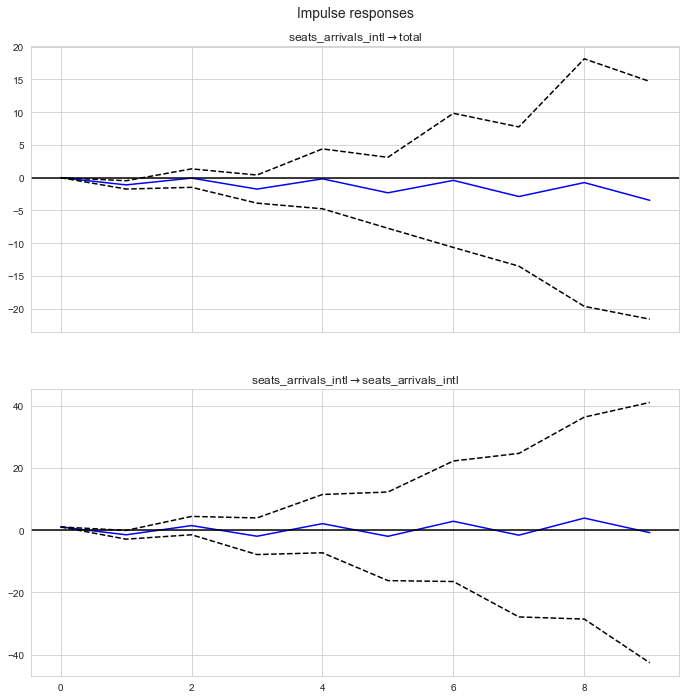

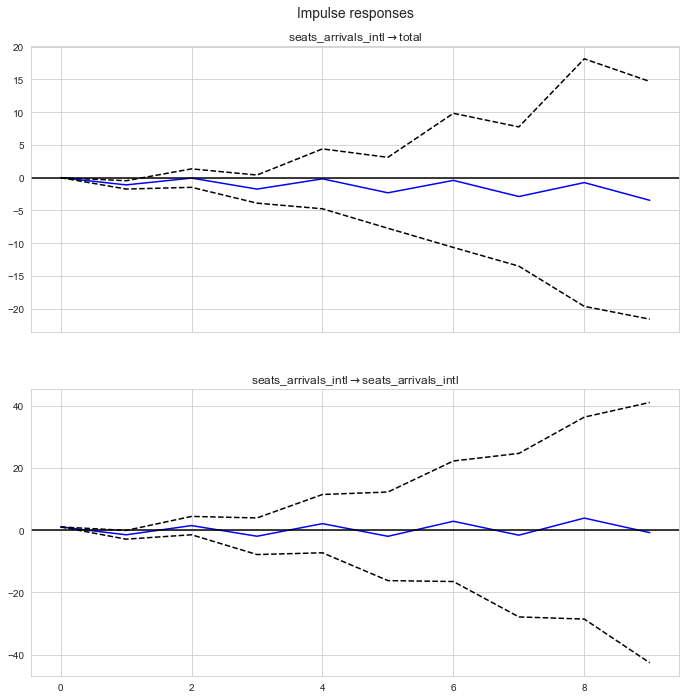

In [49]:
irf = model_fit.irf(9)
irf.plot(impulse='seats_arrivals_intl', orth=False)

In [43]:
# inverse transformation
pred = model_fit.fittedvalues
pred.columns = ["total_pred", "seats_arrivals_intl_pred"]
fj_pred = pd.concat([fj_merged[excl_cols], 
                     fj_merged[["total", "seats_arrivals_intl"]], 
                     pred], axis=1)
fj_pred.head(5)

,year,month,dates,total,seats_arrivals_intl,total_pred,seats_arrivals_intl_pred
0,2020,1,2020-01-01,65386,107570.0,NaN,NaN
1,2020,2,2020-02-01,46343,65187.0,NaN,NaN
2,2020,3,2020-03-01,27972,45688.0,NaN,NaN
3,2020,4,2020-04-01,678,1922.0,13571.233995,-819.232046
4,2020,5,2020-05-01,709,925.0,-2452.583436,-679.760610


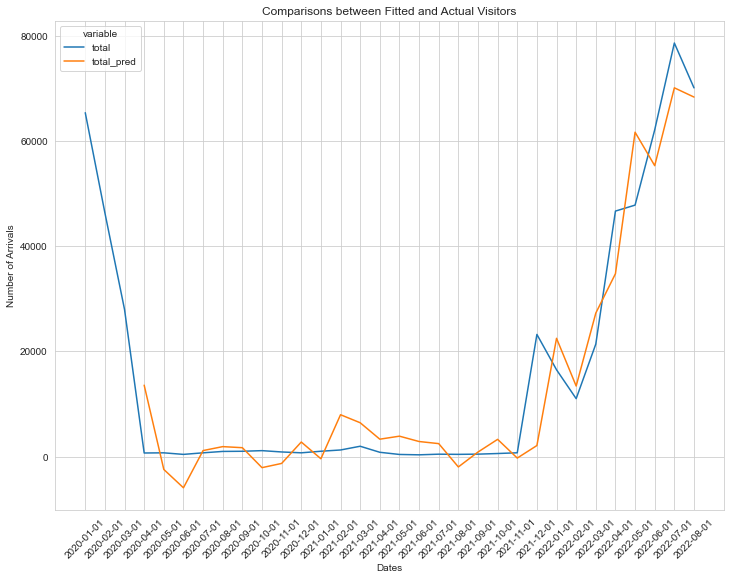

In [44]:
plt.figure(figsize=(12, 9))
sns.lineplot(
    data=fj_pred[["dates", "total", "total_pred"]].melt(id_vars=["dates"]),
    x="dates", y="value", hue="variable")

plt.xlabel("Dates")
plt.ylabel("Number of Arrivals") 
plt.title("Comparisons between Fitted and Actual Visitors")
plt.xticks(rotation=45)
plt.show()

### VECM

In [51]:
from statsmodels.tsa.vector_ar.vecm import *
vecm_lag = select_order(fj_merged[["total", "seats_arrivals_intl"]], maxlags=12)
vecm_lag.summary()

,AIC,BIC,FPE,HQIC
0,38.29,38.59,4.269e+16,38.34
1,37.89,38.39,2.932e+16,37.98
2,37.33,38.03,1.754e+16,37.45
3,36.65,37.54,9.691e+15,36.80
4,36.01,37.10,6.033e+15,36.19
5,35.03,36.33,3.023e+15,35.25
6,33.86,35.35,1.552e+15,34.11
7,30.85,32.54,2.259e+14,31.14
8,-inf*,-inf*,inf,-inf*
9,-88.57,-86.48,1.653e-38,-88.21


In [88]:
vec_rank = select_coint_rank(
    fj_merged[["total", "seats_arrivals_intl"]], det_order=1, k_ar_diff=9, method='trace')
vec_rank.summary()

r_0,r_1,test statistic,critical value
0,2,nan,18.40
1,2,30.82,3.841


In [87]:
vecm_mod = VECM(fj_train, deterministic="ci", k_ar_diff=11, coint_rank=vec_rank.rank)
vecm_res = vecm_mod.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.total_log,0.4964,nan,nan,nan,nan,nan
L1.seats_arrivals_intl_log,-3.4135,nan,nan,nan,nan,nan
L2.total_log,-0.6497,nan,nan,nan,nan,nan
L2.seats_arrivals_intl_log,2.5125,nan,nan,nan,nan,nan
L3.total_log,-0.2490,nan,nan,nan,nan,nan
L3.seats_arrivals_intl_log,0.1880,nan,nan,nan,nan,nan
L4.total_log,0.0467,nan,nan,nan,nan,nan
L4.seats_arrivals_intl_log,3.9301,nan,nan,nan,nan,nan
L5.total_log,-0.5259,nan,nan,nan,nan,nan
L5.seats_arrivals_intl_log,3.1335,nan,nan,nan,nan,nan
